In [7]:
# GENERAL THINGS FOR COMPUTING AND PLOTTING
import pandas as pd
import numpy as np
import os, sys, time
from datetime import datetime
from datetime import timedelta
import scipy as sp

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", context="talk")

# ibl specific things
import datajoint as dj
from ibl_pipeline import reference, subject, action, acquisition, data, behavior
from ibl_pipeline.analyses import behavior as behavioral_analyses

# set path for saving figures
figpath = 'figures' # put in the same folder, but add to .gitignore for now

In [8]:
########### SUBJECTS ########### 

subj = subject.Subject * subject.SubjectLab  & 'lab_name="churchlandlab"'

########### WEIGHINGS ########### 
# grab the data from the start of baseline weights until lab shutdown
weight_with_date = subj * action.Weighing.proj('weight', session_date='DATE(weighing_time)')
weight_date = (dj.U('subject_uuid', 'session_date') & weight_with_date) \
& 'session_date BETWEEN "2020-02-22" AND "2020-03-31"'
#baseline_date = (dj.U('subject_uuid', 'session_date') & weight_with_date) & 'session_date < "2020-02-25"'

avg_weight_date = weight_date.aggr(weight_with_date, avg_weight='AVG(weight)') 
#avg_baseline_weight_date = baseline_date.aggr(weight_with_date, avg_weight = 'AVG(weight)')

b = subj * avg_weight_date 
#bb = subj * avg_baseline_weight_date
weight_df = pd.DataFrame(b.fetch(as_dict=True))
#baseline_df = pd.DataFrame(bb.fetch(as_dict=True))
sorted(weight_df.subject_nickname.unique())

['CSHL022',
 'CSHL024',
 'CSHL025',
 'CSHL026',
 'CSHL027',
 'CSHL029',
 'CSHL031',
 'CSHL045',
 'CSHL046',
 'CSHL058',
 'CSHL059',
 'CSHL060',
 'CSHL061',
 'CSHL062',
 'CSHL063',
 'CSHL064',
 'CSHL065',
 'CSHL066',
 'CSHL067',
 'CSHL068',
 'CSHL069',
 'CSHL070',
 'CSHL071',
 'CSHL072',
 'CSHL073',
 'CSHL074',
 'CSHL075',
 'CSHL_018',
 'CSHL_019']

In [9]:
## save to file for archiving
weight_df[['subject_uuid', 'subject_nickname', 'subject_birth_date', 'sex', 'subject_strain','subject_line', 
           'session_date', 'avg_weight']].to_csv('data/figure1D_cshl_weights.csv')

In [10]:
########### WEIGHINGS NORMALIZATION and ########### 
########### CONVERSION OF SESSION DATES INTO SESSION NUMBERS ########### 

normalized_df = weight_df.copy()

#  how old are these mice on the first day of the intervention?
# 3 March was the first day with CA water
normalized_df['session_age'] = (datetime(2020, 3, 2).date() - normalized_df.subject_birth_date)
normalized_df['session_age'].describe()

########### ADD JAX DATA ########### 
jax_weights = pd.read_csv('data/jax_mouse_weights.csv')
jax_weights.head(n=3)

for weeknr, group in jax_weights.groupby(['Weeks']):
    
    if 44 <= group.Weeks.mean().item() <= 47:
        normalized_df = normalized_df.append({'subject_nickname':'Jax_male',
                              'sex':'M',
                              'session_date':datetime(2020, 3, 2).date() + 
                                              timedelta(days=(group.Weeks.mean().item() - 44) * 7),
                              'avg_weight':group.Males.mean().item()}, ignore_index=True)
        
        normalized_df = normalized_df.append({'subject_nickname':'Jax_female',
                              'sex':'F',
                              'session_date':datetime(2020, 3, 2).date() + 
                                              timedelta(days=(group.Weeks.mean().item() - 44) * 7),
                              'avg_weight':group.Females.mean().item()}, ignore_index=True)
normalized_df
# day 0 is the start of the experiment
normalized_df['session_day'] = (normalized_df['session_date'] - (datetime(2020, 3, 2)).date()).dt.days


In [11]:
normalized2 = pd.DataFrame([])
for index, sjdat in normalized_df.groupby(['subject_nickname']):
    sjdat['avg_weight'] = sjdat['avg_weight'] / sjdat.loc[sjdat.session_day < 1, 'avg_weight'].mean()
    normalized2 = normalized2.append(sjdat)

########### CONDITIONS ########### 
CA = 'Citric Acid'
Jax = 'Jax'

# condition_map = {'CSHL061':CA, 'CSHL062':CA, 'CSHL063':CA, 'CSHL064':CA, 
# 'CSHL065': CA, 'CSHL066':CA, 'CSHL067':CA, 'CSHL068':CA, 'CSHL069':CA,
# 'CSHL070':CA, 'CSHL071':CA, 'CSHL072':CA, 'CSHL073':CA, 
# 'CSHL074':CA, 'CSHL075':CA}
# 071 was overweight at the start
# CSHL061, 062, 064 had surgery during the CA experiment - exclude

# remove mice that have dropped out
condition_map = {'CSHL063':CA, 'CSHL065': CA, 'CSHL066':CA, 'CSHL067':CA, 'CSHL068':CA, 'CSHL069':CA,
                 'CSHL070':CA, 'CSHL072':CA, 'CSHL073':CA, 'CSHL074':CA, 'CSHL075':CA, 
                 'Jax_male':Jax, 'Jax_female':Jax}

normalized2['condition'] = normalized2.subject_nickname.map(condition_map)

# choose only these animals
normalized2 = normalized2.loc[normalized2.subject_nickname.isin(condition_map.keys()), :]
normalized2.groupby(['subject_nickname'])['sex'].unique()
normalized2['subject_nickname'].unique()
#normalized2.groupby(['sex'])['subject_nickname'].unique()
#normalized2.subject_nickname.nunique()

/anaconda3/envs/iblenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array(['CSHL063', 'CSHL065', 'CSHL066', 'CSHL067', 'CSHL068', 'CSHL069',
       'CSHL070', 'CSHL072', 'CSHL073', 'CSHL074', 'CSHL075',
       'Jax_female', 'Jax_male'], dtype=object)

In [12]:
# # compute age range
# normalized_df['session_age'] = (normalized_df.session_date - normalized_df.subject_birth_date)
# normalized_df.session_age.describe()

In [13]:
# what's the maximum weight loss?
normalized2.avg_weight.describe()

count    244.000000
mean       0.894621
std        0.080425
min        0.716134
25%        0.825746
50%        0.886780
75%        0.986811
max        1.043427
Name: avg_weight, dtype: float64

In [14]:
normalized2.groupby(['subject_nickname'])['avg_weight'].min()

subject_nickname
CSHL063       0.716134
CSHL065       0.788118
CSHL066       0.801421
CSHL067       0.767575
CSHL068       0.787897
CSHL069       0.771154
CSHL070       0.810255
CSHL072       0.770467
CSHL073       0.797905
CSHL074       0.867459
CSHL075       0.830707
Jax_female    1.000000
Jax_male      1.000000
Name: avg_weight, dtype: float64

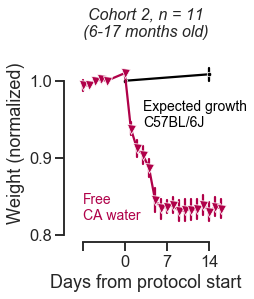

In [15]:
# REMOVE ONE OVERWEIGHT MOUSE
#normalized3 = normalized2[~normalized2['subject_nickname'].isin(['CSHL071'])]
f, ax = plt.subplots(ncols=1, nrows=1, figsize=(3.6,4.5))
    
palette = sns.xkcd_palette(['black', 'raspberry'])
sns.lineplot(x="session_day", y="avg_weight", style='condition', hue='condition',
             markers={'Jax':'.', 'Citric Acid':'v'}, 
             err_style='bars', marker='v', hue_order=['Jax', 'Citric Acid'], dashes=False,
             ci=68, data=normalized2, ax=ax, legend=False, palette=palette)
ax.set_xlabel("Days from protocol start")    
ax.set_ylabel("Weight (normalized)")     
ax.set(ylim=[0.79, 1.05], yticks=[0.8, 0.9, 1], xticks=[-7, 0, 7, 14], 
       xticklabels=['', '0', '7', '14'], xlim=[-10, 17])
#ax.text(-5, 0.85, 'n = %d'%normalized3.subject_nickname.nunique(), {'color':'k', 'fontsize':16})
ax.set_title('Cohort 2, n = %d\n(6-17 months old)'%(normalized2.subject_nickname.nunique()-2), 
            fontsize=16, fontstyle='italic')

ax.text(3, 0.94,'Expected growth\nC57BL/6J', {'color':palette[0], 'fontsize':14})
ax.text(-7, 0.82,'Free\nCA water', {'color':palette[1], 'fontsize':14})

f.tight_layout()
sns.despine(trim=True)
f.savefig(os.path.join(figpath, "citricacid_study1d.pdf"))
f.savefig(os.path.join(figpath, "citricacid_study1d.png"), dpi=600)

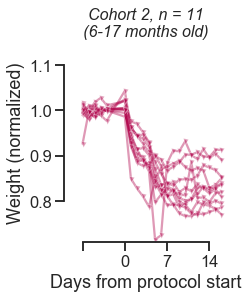

In [16]:
# REMOVE ONE OVERWEIGHT MOUSE
#normalized3 = normalized2[~normalized2['subject_nickname'].isin(['CSHL071'])]
f, ax = plt.subplots(ncols=1, nrows=1, figsize=(3.6,4.5))
    
palette = sns.xkcd_palette(['raspberry'])
sns.lineplot(x="session_day", y="avg_weight", hue='condition', units='subject_nickname',estimator=None,
             err_style='bars', marker='v', alpha=0.4, palette=palette,
            markers={'Jax':'o', 'Citric Acid':'v'}, 
             style='condition', dashes=False, markersize=5,
             hue_order=['Citric Acid'], 
             ci=68, data=normalized2, ax=ax, legend=False)
ax.set_xlabel("Days from protocol start")    
ax.set_ylabel("Weight (normalized)")     
ax.set(ylim=[0.71, 1.15], yticks=[0.7, 0.8, 0.9, 1, 1.1],xticks=[-7, 0, 7, 14], 
       xticklabels=['', '0', '7', '14'], xlim=[-10, 17])
#ax.text(-5, 0.85, 'n = %d'%normalized3.subject_nickname.nunique(), {'color':'k', 'fontsize':16})
ax.set_title('Cohort 2, n = %d\n(6-17 months old)'%(normalized2.subject_nickname.nunique()-2), 
            fontsize=16, fontstyle='italic')
f.tight_layout()
sns.despine(trim=True)
f.savefig(os.path.join(figpath, "citricacid_study1d_individualmice.pdf"))

In [17]:
# what were the weights in the last week?
normalized3 = normalized2.loc[(normalized2.session_day > 7) & ~(normalized2['condition'].str.contains('Jax')), 
                              :].groupby(['subject_nickname'])['avg_weight'].mean()
normalized3.describe().round(2)

count    11.00
mean      0.83
std       0.04
min       0.78
25%       0.80
50%       0.82
75%       0.86
max       0.91
Name: avg_weight, dtype: float64

In [18]:
thirst = pd.read_csv('data/figure1D_cshl_thirst.csv', parse_dates=['Date'])
thirst['date'] = thirst['Date'].dt.date
thirst['session_day'] = (thirst['date'] - (datetime(2020, 3, 2)).date()).dt.days

# unstack
thirst = pd.melt(thirst, id_vars=['session_day'], value_vars=['Avg_permouse_1', 'Av_permouse_2', 
                                                       'Avg_permouse_3'])

In [13]:
# f, ax = plt.subplots(ncols=1, nrows=1, figsize=(4, 4))    
# palette = sns.xkcd_palette(['black', 'raspberry'])
# sns.lineplot(x="session_day", y="value", 
#              err_style='bars', marker='o', 
#              ci=68, data=thirst, ax=ax, legend=False, color=palette[1])
# ax.set_xlabel("Days from protocol start")    
# ax.set_ylabel("2% CA water consumed")     
# ax.set(ylim=[0,6], yticks=[0, 3, 6], xticks=[-7, 0, 7, 14], xlim=[-1, 17])
# #ax.text(-5, 0.85, 'n = %d'%normalized3.subject_nickname.nunique(), {'color':'k', 'fontsize':16})
# ax.set_title('Cohort 3, n = %d (6-17 months)'%(normalized2.subject_nickname.nunique()-2), 
#             fontsize=16, fontstyle='italic')
# f.tight_layout()
# sns.despine(trim=True)
# #f.savefig(os.path.join(figpath, "citricacid_weights_churchlandlab.pdf"))
# f.savefig(os.path.join(figpath, "suppfig2b.png"), dpi=600)


In [14]:
# #normalized3 = normalized2[~normalized2['subject_nickname'].isin(['CSHL071'])]
# f, ax = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
    
# palette = sns.xkcd_palette(['black', 'raspberry'])
# sns.lineplot(x="session_day", y="avg_weight", hue='condition', 
#              err_style='bars', marker='o', hue_order=['Jax', 'Citric Acid'],
#              ci=68, data=normalized2, ax=ax[0], legend=False, palette=palette)
# ax[0].set_xlabel("Days from protocol start")    
# ax[0].set_ylabel("Weight (norm.)")     
# ax[0].set(ylim=[0.79, 1.08], yticks=[0.8, 0.9, 1], xticks=[-7, 0, 7, 14], xlim=[-10, 17])
# #ax.text(-5, 0.85, 'n = %d'%normalized3.subject_nickname.nunique(), {'color':'k', 'fontsize':16})
# #ax[0].set_title()

# sns.lineplot(x="session_day", y="value", 
#              err_style='bars', marker='o', 
#              ci=68, data=thirst, ax=ax[1], legend=False, color=palette[1])
# ax[1].set_xlabel("Days from protocol start")    
# ax[1].set_ylabel("2% CA water consumed")     
# ax[1].set(ylim=[0,6], yticks=[0, 2, 4], xticks=[-7, 0, 7, 14], xlim=[-1, 17])
# #ax.text(-5, 0.85, 'n = %d'%normalized3.subject_nickname.nunique(), {'color':'k', 'fontsize':16})
# # ax=ax[1].set_title('Cohort 3, n = %d (6-17 months)'%(normalized3.subject_nickname.nunique()-2), 
# #             fontsize=16, fontstyle='italic')

# f.suptitle('Cohort 3, n = %d (6-17 months)'%(normalized2.subject_nickname.nunique()-2), 
#             fontsize=16, fontstyle='italic')

# f.tight_layout()
# sns.despine(trim=True)
# #f.savefig(os.path.join(figpath, "citricacid_weights_churchlandlab.pdf"))
# f.savefig(os.path.join(figpath, "suppfig2_2panels.png"), dpi=600)
